In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from biosppy.signals import ecg
import numpy as np
# open the csv file
df = pd.read_csv('data/mit-bih/compiled_mit_bih.csv')
print(df.head())



       0      1      2      3      4      5      6      7      8      9  ...  \
0 -0.390 -0.395 -0.390 -0.405 -0.405 -0.400 -0.375 -0.380 -0.390 -0.395  ...   
1 -0.405 -0.410 -0.410 -0.410 -0.410 -0.400 -0.385 -0.370 -0.375 -0.360  ...   
2 -0.385 -0.365 -0.375 -0.380 -0.390 -0.385 -0.375 -0.360 -0.370 -0.380  ...   
3 -0.360 -0.360 -0.360 -0.360 -0.380 -0.390 -0.395 -0.375 -0.405 -0.450  ...   
4 -0.450 -0.445 -0.450 -0.455 -0.445 -0.450 -0.440 -0.430 -0.415 -0.425  ...   

    3591   3592   3593   3594   3595   3596   3597   3598   3599  label  
0 -0.405 -0.415 -0.405 -0.405 -0.405 -0.410 -0.425 -0.430 -0.420      N  
1 -0.380 -0.390 -0.375 -0.365 -0.365 -0.375 -0.375 -0.385 -0.385      N  
2 -0.360 -0.375 -0.370 -0.370 -0.360 -0.365 -0.375 -0.380 -0.385      N  
3 -0.415 -0.440 -0.445 -0.435 -0.425 -0.430 -0.440 -0.465 -0.460      N  
4 -0.220 -0.225 -0.235 -0.220 -0.220 -0.210 -0.230 -0.245 -0.245      N  

[5 rows x 3601 columns]


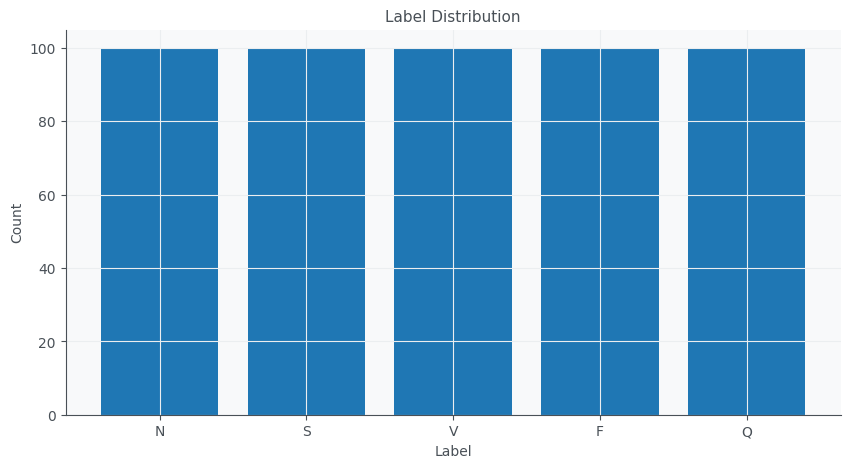

In [14]:
# plot the label distribution
labels = df.label.value_counts()

plt.figure(figsize=(10, 5))
plt.bar(labels.index, labels.values)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Record: 0
Label: N
Signal shape: (3600,)

First few samples:
[-0.39  -0.395 -0.39  -0.405 -0.405]


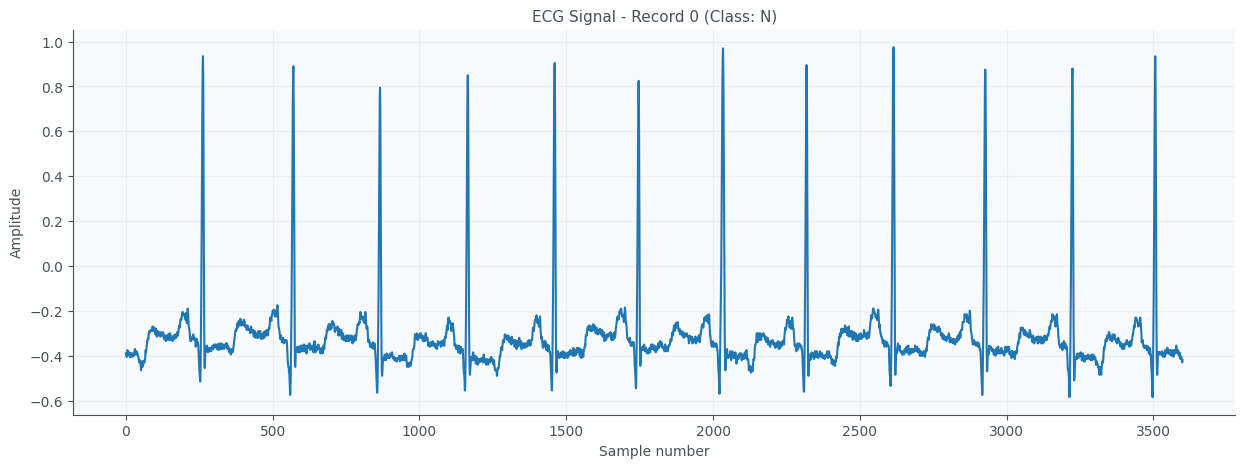

array([-0.39 , -0.395, -0.39 , ..., -0.425, -0.43 , -0.42 ])

In [15]:
def plot_ecg_record(ecg_signal, record_name, label):

    
    # Print record information
    print(f"Record: {record_name}")
    print(f"Label: {label}")
    print(f"Signal shape: {ecg_signal.shape}")
    print("\nFirst few samples:")
    print(ecg_signal[:5])
    
    # Plot the signal
    plt.figure(figsize=(15, 5))
    plt.plot(ecg_signal)
    plt.title(f'ECG Signal - Record {record_name} (Class: {label})')
    plt.xlabel('Sample number')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    
    return ecg_signal

labels = df.label
ecg_signal = df.drop(columns=['label']).values
record_index = 0
plot_ecg_record(ecg_signal[record_index], record_index, df.iloc[record_index].label)


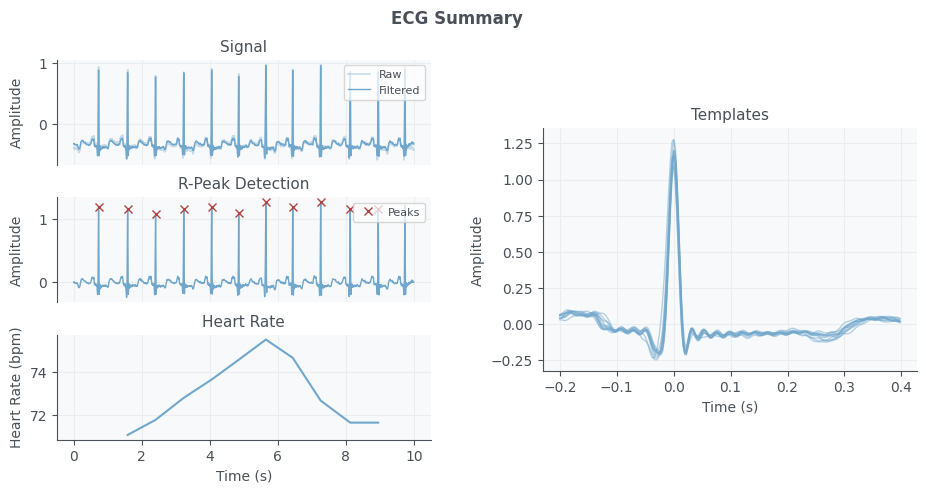

Available outputs: ['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']


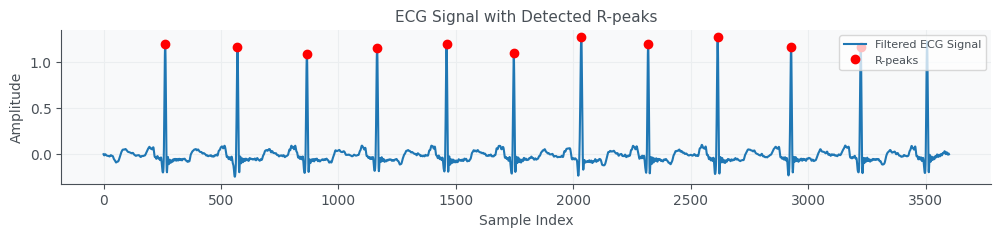

In [16]:
from biosppy.signals import ecg

# lets use pan tompkins to detect the afib

# Test the function with a single record

record_index = 0

out = ecg.ecg(signal=ecg_signal[record_index], sampling_rate=360, show=True)
# Print all available keys
print("Available outputs:", out.keys())

# Extract the processed signal and R-peak locations
filtered_ecg = out['filtered']
r_peaks = out['rpeaks']

# Plot the ECG signal with R-peaks
plt.figure(figsize=(12, 2))
plt.plot(filtered_ecg, label="Filtered ECG Signal")
plt.plot(r_peaks, filtered_ecg[r_peaks], "ro", label="R-peaks")  # Mark R-peaks with red dots
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-peaks")
plt.legend()
plt.show()

In [18]:
# Create a reusable function for Pan-Tompkins algorithm
def compute_pan_tompkins(ecg_signal):
    out = ecg.ecg(signal=ecg_signal, sampling_rate=300, show=False)

    filtered_ecg = out['filtered']
    r_peaks = out['rpeaks']
    heart_rate = out['heart_rate']

    # convert r_peaks to seconds
    r_peaks_seconds = r_peaks / 360

    # Compute RR intervals
    rr_intervals = np.diff(r_peaks_seconds)

    # Compute mean and std of the RR intervals
    rr_mean = np.mean(rr_intervals)
    rr_std = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(r_peaks_seconds))))

    # Calculate pNN50
    pnn50 = np.sum(np.abs(np.diff(r_peaks_seconds)) > 0.05) / len(rr_intervals)

    # Compute heart rate features
    if len(heart_rate) > 0:
        hr_mean = np.mean(heart_rate)
        hr_std = np.std(heart_rate)
        min_hr = np.min(heart_rate)
        max_hr = np.max(heart_rate)
    else:
        hr_mean = np.nan
        hr_std = np.nan
        min_hr = np.nan
        max_hr = np.nan

    # compute signal features
    signal_power = np.sum(np.square(filtered_ecg))
    signal_entropy = -np.sum(np.square(filtered_ecg) * np.log2(np.square(filtered_ecg)))
    signal_energy = np.sum(np.square(filtered_ecg))
    signal_power = signal_power / len(filtered_ecg)

    # irregularity features
    irregularity_mean = np.mean(np.diff(r_peaks_seconds))
    irregularity_std = np.std(np.diff(r_peaks_seconds))
    rr_coefficient = np.std(rr_intervals) / np.mean(rr_intervals)

    features = {
        'rr_mean': rr_mean,
        'rr_std': rr_std,
        'rmssd': rmssd,
        'pnn50': pnn50,
        'hr_mean': hr_mean,
        'hr_std': hr_std,
        'min_hr': min_hr,
        'max_hr': max_hr,
        'signal_power': signal_power,
        'signal_entropy': signal_entropy,
        'irregularity_mean': irregularity_mean,
        'irregularity_std': irregularity_std,
        'rr_coefficient': rr_coefficient
    }

    return features

# Test the function with a single record
record_index = 0
features = compute_pan_tompkins(ecg_signal[record_index])
print(features)

{'rr_mean': np.float64(0.8225), 'rr_std': np.float64(0.023715455709435142), 'rmssd': np.float64(0.822841827351713), 'pnn50': np.float64(1.0), 'hr_mean': np.float64(60.8402553948301), 'hr_std': np.float64(1.2088510364194842), 'min_hr': np.float64(59.358218153006426), 'max_hr': np.float64(62.939114875734596), 'signal_power': np.float64(0.026342626780620288), 'signal_entropy': np.float64(93.71852892475876), 'irregularity_mean': np.float64(0.8225), 'irregularity_std': np.float64(0.023715455709435142), 'rr_coefficient': np.float64(0.028833380801744853)}


In [19]:
# Process all the records
all_features = []
for i, label in enumerate(labels):
    features = compute_pan_tompkins(ecg_signal[i])
    # include the record name and label
    features['record_name'] = i
    features['label'] = label
    all_features.append(features)
    if i % 10 == 0:
        print(f'Processed {i} records')

# Convert to DataFrame
features_df = pd.DataFrame(all_features)
features_df.to_csv('results/mit_bih_pan_tomkins_features.csv', index=False)

Processed 0 records
Processed 10 records
Processed 20 records
Processed 30 records
Processed 40 records
Processed 50 records
Processed 60 records
Processed 70 records
Processed 80 records
Processed 90 records
Processed 100 records
Processed 110 records
Processed 120 records
Processed 130 records
Processed 140 records
Processed 150 records
Processed 160 records
Processed 170 records
Processed 180 records
Processed 190 records
Processed 200 records
Processed 210 records
Processed 220 records
Processed 230 records
Processed 240 records
Processed 250 records
Processed 260 records
Processed 270 records
Processed 280 records
Processed 290 records
Processed 300 records
Processed 310 records
Processed 320 records
Processed 330 records
Processed 340 records
Processed 350 records
Processed 360 records
Processed 370 records
Processed 380 records
Processed 390 records
Processed 400 records
Processed 410 records
Processed 420 records
Processed 430 records
Processed 440 records
Processed 450 records